# Stress Analysis in Social Media

Leverage the newly published and labelled reddit dataset for stress analysis to develop and improve supervised learning methods for identifying stress, both neural and traditional, and analyze the complexity and diversity of the data and characteristics of each category.

In [12]:
import os
import re
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

In [2]:
print(tf.__version__)

1.15.3-dlenv_tfe


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5546638750167621165
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14622910942808340127
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11877495865386256200
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15848577434
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10551595464284002639
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [4]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import logging, sys
logging.disable(sys.maxsize)

## Data

In [7]:
path = '../../data/preprocessed/' 
# path = '/content/Insight_Stress_Analysis/data/'
train = pd.read_pickle(path + 'train.pkl')
test = pd.read_pickle(path + 'test.pkl')

(array([   2.,   34.,  865.,    0.,   85.,    0.,  595.,  129.,    0.,
        1128.]),
 array([0.42857143, 0.48571429, 0.54285714, 0.6       , 0.65714286,
        0.71428571, 0.77142857, 0.82857143, 0.88571429, 0.94285714,
        1.        ]),
 <a list of 10 Patch objects>)

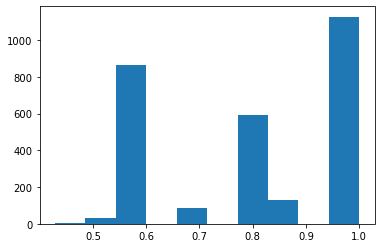

In [13]:
plt.hist(train['confidence'])

(array([ 98.,   0.,   0.,   0.,   0., 153.,  18.,   1., 180., 265.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

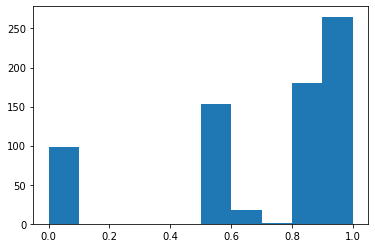

In [14]:
plt.hist(test['confidence'])

In [17]:
train = train[train['confidence']>0.8]
test = test[test['confidence']>0.8]

In [18]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0, 1]

#Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves two steps. First, we create  `InputExample`'s using the constructor provided in the BERT library.

- `text_a` is the text we want to classify, which in this case, is the `Request` field in our Dataframe. 
- `text_b` is used if we're training a model to understand the relationship between sentences (i.e. is `text_b` a translation of `text_a`? Is `text_b` an answer to the question asked by `text_a`?). This doesn't apply to our task, so we can leave `text_b` blank.
- `label` is the label for our example, i.e. True, False

In [19]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

test_InputExamples = test.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Next, we need to preprocess our data so that it matches the data BERT was trained on. For this, we'll need to do a couple of things (but don't worry--this is also included in the Python library):


1. Lowercase our text (if we're using a BERT lowercase model)
2. Tokenize it (i.e. "sally says hi" -> ["sally", "says", "hi"])
3. Break words into WordPieces (i.e. "calling" -> ["call", "##ing"])
4. Map our words to indexes using a vocab file that BERT provides
5. Add special "CLS" and "SEP" tokens (see the [readme](https://github.com/google-research/bert))
6. Append "index" and "segment" tokens to each input (see the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

Happily, we don't have to worry about most of these details.




In [20]:
# Load a vocabulary file and lowercasing information directly from the BERT tf hub module

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(BERT_MODEL_HUB)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                                tokenization_info["do_lower_case"]])

    return bert.tokenization.FullTokenizer(vocab_file=vocab_file, 
                                    do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

In [21]:
# Set the maximum sequence length. 
def get_max_len(text):
    max_len = 0
    for i in range(len(train)):
        if len(text.iloc[i]) > max_len:
            max_len = len(text.iloc[i])
    return max_len

temp = train.text.str.split(' ')
max_len = get_max_len(temp)

In [22]:
MAX_SEQ_LENGTH = max_len
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, 
                                                                  label_list, 
                                                                  MAX_SEQ_LENGTH, 
                                                                  tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, 
                                                                 label_list, 
                                                                 MAX_SEQ_LENGTH, 
                                                                 tokenizer)

## Classification Model

Now that we've prepared our data, let's focus on building a model. `create_model` does just this below. First, it loads the BERT tf hub module again (this time to extract the computation graph). Next, it creates a single new layer that will be trained to adapt BERT to our sentiment task (i.e. classifying whether a movie review is positive or negative). This strategy of using a mostly trained model is called [fine-tuning](http://wiki.fast.ai/index.php/Fine_tuning).

In [23]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
    """Creates a classification model."""

    bert_module = hub.Module(BERT_MODEL_HUB, trainable=True)
    bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
    bert_outputs = bert_module(inputs=bert_inputs, signature="tokens", as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    hidden_size = output_layer.shape[-1].value

    # Create our own layer to tune for politeness data.
    output_weights = tf.get_variable(
        "output_weights", [num_labels, hidden_size],
        initializer=tf.truncated_normal_initializer(stddev=0.02))

    output_bias = tf.get_variable("output_bias", 
                                  [num_labels], 
                                  initializer=tf.zeros_initializer())

    with tf.variable_scope("loss"):

        # Dropout helps prevent overfitting
        output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

        logits = tf.matmul(output_layer, output_weights, transpose_b=True)
        logits = tf.nn.bias_add(logits, output_bias)
        log_probs = tf.nn.log_softmax(logits, axis=-1)

        # Convert labels into one-hot encoding
        one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

        predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
        # If we're predicting, we want predicted labels and the probabiltiies.
        if is_predicting:
            return (predicted_labels, log_probs)

        # If we're train/eval, compute loss between predicted and actual label
        per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
        loss = tf.reduce_mean(per_example_loss)
        return (loss, predicted_labels, log_probs)

Next we'll wrap our model function in a `model_fn_builder` function that adapts our model to work for training, evaluation, and prediction.

In [24]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps, num_warmup_steps):
    """Returns `model_fn` closure for TPUEstimator."""
    def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""
        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
        # TRAIN and EVAL
        if not is_predicting:
            (loss, predicted_labels, log_probs) = create_model(is_predicting, 
                                                               input_ids, 
                                                               input_mask, 
                                                               segment_ids, 
                                                               label_ids, 
                                                               num_labels)

            train_op = bert.optimization.create_optimizer(loss, 
                                                          learning_rate, 
                                                          num_train_steps, 
                                                          num_warmup_steps, 
                                                          use_tpu=False)

            # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(label_ids, predicted_labels)
                auc = tf.metrics.auc(label_ids, predicted_labels)
                recall = tf.metrics.recall(label_ids, predicted_labels)
                precision = tf.metrics.precision(label_ids, predicted_labels) 
                true_pos = tf.metrics.true_positives(label_ids, predicted_labels)
                true_neg = tf.metrics.true_negatives(label_ids, predicted_labels)   
                false_pos = tf.metrics.false_positives(label_ids, predicted_labels)  
                false_neg = tf.metrics.false_negatives(label_ids, predicted_labels)

                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
            else:
                return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(is_predicting, 
                                                         input_ids, 
                                                         input_mask, 
                                                         segment_ids, 
                                                         label_ids, 
                                                         num_labels)

            predictions = {'probabilities': log_probs, 'labels': predicted_labels}
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn

In [25]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 8
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [26]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [27]:
# Specify outpit directory and number of checkpoint steps to save
OUTPUT_DIR = 'output'

run_config = tf.estimator.RunConfig(model_dir=OUTPUT_DIR,
                                    save_summary_steps=SAVE_SUMMARY_STEPS,
                                    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [28]:
model_fn = model_fn_builder(num_labels=len(label_list), 
                            learning_rate=LEARNING_RATE,
                            num_train_steps=num_train_steps,
                            num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   config=run_config,
                                   params={"batch_size": BATCH_SIZE})

Next we create an input builder function that takes our training feature set (`train_features`) and produces a generator. This is a pretty standard design pattern for working with Tensorflow [Estimators](https://www.tensorflow.org/guide/estimators).

In [29]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(features=train_features,
                                                      seq_length=MAX_SEQ_LENGTH,
                                                      is_training=True,
                                                      drop_remainder=False)

Now we train our model! For me, using a Colab notebook running on Google's GPUs, my training time was about 14 minutes.

In [30]:
print(f'Beginning Training!')
current_time = datetime.now()

# train the model 
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

print("Training took time ", datetime.now() - current_time)

Beginning Training!
Training took time  0:03:48.131239


In [31]:
# check the test result
test_input_fn = run_classifier.input_fn_builder(features=test_features,
                                                seq_length=MAX_SEQ_LENGTH,
                                                is_training=False,
                                                drop_remainder=False)

In [33]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

{'auc': 0.927437,
 'eval_accuracy': 0.9295302,
 'f1_score': 0.9373134,
 'false_negatives': 9.0,
 'false_positives': 12.0,
 'loss': 0.32066914,
 'precision': 0.92899406,
 'recall': 0.94578314,
 'true_negatives': 120.0,
 'true_positives': 157.0,
 'global_step': 471}

In [34]:
def predict(in_sentences):
    labels = ["non-stress", "stress"]
    labels_idx = [0, 1]
    input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label

    input_features = run_classifier.convert_examples_to_features(input_examples, 
                                                                 labels_idx, 
                                                                 MAX_SEQ_LENGTH, 
                                                                 tokenizer)
    
    predict_input_fn = run_classifier.input_fn_builder(features=input_features, 
                                                       seq_length=MAX_SEQ_LENGTH, 
                                                       is_training=False, 
                                                       drop_remainder=False)

    predictions = estimator.predict(predict_input_fn)
    return [{"text": sentence, "confidence": list(prediction['probabilities']), "labels": labels[prediction['labels']]}
            for sentence, prediction in zip(in_sentences, predictions)]


In [82]:
pred_sentences = ['I have nowhere I can stay. I\'m even getting rid of my beloved cat so I can have options.',
    'i wanna die i swear i havent been so helpless and scared in so long.',
    'I feel so hopeless about everything.',
    "It's Friday! We wish you a nice start into the weekend!",
"Deep breathing exercises are very relaxing. It can also relieve the symptoms of stress and anxiety.",
"Do you like fruits? I like so much! Be Happy, Keep Smiling!"
]

In [83]:
predictions = predict(pred_sentences)
predictions

[{'text': "I have nowhere I can stay. I'm even getting rid of my beloved cat so I can have options.",
  'confidence': [-4.6344376, -0.009758978],
  'labels': 'stress'},
 {'text': 'i wanna die i swear i havent been so helpless and scared in so long.',
  'confidence': [-6.711318, -0.0012178156],
  'labels': 'stress'},
 {'text': 'I feel so hopeless about everything.',
  'confidence': [-6.72842, -0.0011970982],
  'labels': 'stress'},
 {'text': "It's Friday! We wish you a nice start into the weekend!",
  'confidence': [-0.0007175017, -7.2401576],
  'labels': 'non-stress'},
 {'text': 'Deep breathing exercises are very relaxing. It can also relieve the symptoms of stress and anxiety.',
  'confidence': [-0.0010567086, -6.853126],
  'labels': 'non-stress'},
 {'text': 'Do you like fruits? I like so much! Be Happy, Keep Smiling!',
  'confidence': [-0.0009835887, -6.9248033],
  'labels': 'non-stress'}]

In [77]:
small = test[:10]
pred_sentences = small['text']
predictions = predict(pred_sentences)

In [80]:
for input, prediction, label in zip (pred_sentences, predictions,small['label']):
    if (prediction['labels'] == "non-stress" and label==1) or (prediction['labels'] == "stress" and label==0):
        print(input, '\n has been classified as', prediction['labels'], 'and should be ', label)

PTSD is life changing for the worse. Every day fight. Getting in a fist fight in high school( who did not get into a fight)  I'm not talking about bullying,  Playing video games,  having bad dreams does not cause PTSD. We have seen things, or done things or ,been part of things,  that most people will never understand and hopefully never experience. End of Rant 
 has been classified as non-stress and should be  1


## Save Ckpts to PB file

In [ ]:
import os
import tensorflow as tf

trained_checkpoint_prefix = 'Learn2Relax/learn2relax/notebooks/output/model.ckpt-471'
export_dir = './bert_output/'

graph = tf.Graph()
with tf.compat.v1.Session(graph=graph) as sess:
    # Restore from checkpoint
    loader = tf.compat.v1.train.import_meta_graph(trained_checkpoint_prefix + '.meta')
    loader.restore(sess, trained_checkpoint_prefix)

#     # Export checkpoint to SavedModel
    builder = tf.compat.v1.saved_model.builder.SavedModelBuilder(export_dir)
    builder.add_meta_graph_and_variables(sess,
                                         [tf.saved_model.TRAINING, tf.saved_model.SERVING],
                                         strip_default_attrs=True)
    builder.save()   

## BERT fine-tuned model for Tensorflow serving
Reference: https://medium.com/delvify/bert-rest-inference-from-the-fine-tuned-model-499997b32851

In [72]:
def serving_input_fn():
    label_ids = tf.placeholder(tf.int32, [None], name='label_ids')
    input_ids = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='input_ids')
    input_mask = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='input_mask')
    segment_ids = tf.placeholder(tf.int32, [None, MAX_SEQ_LENGTH], name='segment_ids')
    input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({
        'label_ids': label_ids,
        'input_ids': input_ids,
        'input_mask': input_mask,
        'segment_ids': segment_ids,
    })()
    return input_fn

In [73]:
estimator._export_to_tpu = False
estimator.export_savedmodel(OUTPUT_DIR, serving_input_fn)

b'output/1592238437'

In [50]:
# !saved_model_cli show --dir /home/gillianchiang/Insight_Stress_Analysis/framework/output/1581039388/ --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_ids'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 310)
        name: input_ids_1:0
    inputs['input_mask'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 310)
        name: input_mask_1:0
    inputs['label_ids'] tensor_info:
        dtype: DT_INT32
        shape: (-1)
        name: label_ids_1:0
    inputs['segment_ids'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 310)
        name: segment_ids_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['labels'] tensor_info:
        dtype: DT_INT32
        shape: unknown_rank
        name: loss/Squeeze:0
    outputs['probabilities'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: loss/LogSoftmax:0
  Method name is: tensorflow/serving/predict


In [ ]:
# !tensorflow_model_server --port=8500 --rest_api_port=8501 --model_name=/models/output/